In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import data_reshape, split_helper, load_parameters

2025-04-11 00:15:40.814575: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 00:15:40.815560: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 00:15:40.818601: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 00:15:40.827084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744323340.841926 2752913 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744323340.84

In [2]:
import pandas as pd
import numpy as np
import pickle
from functools import partial
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#!/usr/bin/env python
# coding: utf-8

"""
A script/notebook to compare BiLSTM vs LightGBM across multiple window sizes
for one or more datasets (e.g. 'st', 'randomized').
Assumes:
 - Each window-specific BiLSTM model is saved at models/bilstm/{dataset}_bilstm_win{w}.h5
 - The single LightGBM model is saved at models/lightgbm/{dataset}_model.pkl
 - multi_window_size is defined in your .yaml files
 - The same data_path + CSV structure is used for test sets
"""
from tensorflow.keras.metrics import MeanAbsoluteError
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# Local modules (adjust imports if your structure is different)
from training.preprocess import preprocess_and_window, load_parameters
from training.feature_extraction import extract_features

In [3]:
# BILSTM model -----------------------------------------------------------------------
# the input features of the BiLSTM model
features_bilstm = ['voltage', 'current', 'temperature', 'relativeTime']
labels_bilstm = ['capacity']

# load the model


# the BiLSTM model's input features need to be normalized
folder_path = 'data/st/'
path_dict = {'train': f'{folder_path}train.csv',
             'valid': f'{folder_path}valid.csv',
             'test': f'{folder_path}test.csv'}
data_dict = {key: pd.read_csv(path) for key, path in path_dict.items()}
data = pd.concat(data_dict, axis=0)
scaler = MinMaxScaler()
data[features_bilstm] = scaler.fit_transform(data[features_bilstm])
# split tha dataset into train, valid, test
unique_cycles = data['cycle'].unique()
# Example: 70% train+val, 30% test
trainval_cycles, test_cycles = train_test_split(
    unique_cycles, test_size=0.2, random_state=42
)
test_bilstm = data[data['cycle'].isin(test_cycles)]
# BILSTM model ------------------------------------------------------------------------



In [4]:
# LightGBM model -----------------------------------------------------------------------
# the input features of the LightGBM model
params = load_parameters('training/lightgbm.yaml').datasets['st']
features_lgb = params['feature_list']
labels_lgb = params['labels']

# load the model
# with open('model_lightgbm/model_pruning/pruned_nasa_3features_first20_01886500/pruned_110trees_0199.pkl', 'rb') as file:
#     model_lgb = pickle.load(file)
with open('models/lightgbm/lgbm_st_model.pkl', 'rb') as file:
    model_lgb = pickle.load(file)

# the testing data
test_lgb = pd.read_csv('data/st/test.csv')
# LightGBM model -----------------------------------------------------------------------

In [5]:
data_groupby = ['cycle', 'capacity']
# step_len_list = [5, 10, 15, 20, 30, 40, 50, 70, 100]
step_len_list = [20]
# step_len_list = [5, 10, 15, 20, 30, 40, 50]

# get the group size
group_sizes = test_lgb.groupby(data_groupby).size()
max_group_length, min_group_length = group_sizes.max(), group_sizes.min()
print(f"--group length: max={max_group_length}, min={min_group_length}\n")
fixed_group_length = min_group_length

# test and save the result onto dataframe
columns = ['model', 'step_length', 'ordinal', 'MAE', 'loss']
result = pd.DataFrame(columns=columns)

--group length: max=360, min=175



In [6]:
# BILSTM model ----------------------------------------------------
model_bilstm_path = 'models/bilstm/st_bilstm_'
model_bilstm_dict = {
    '5': f'{model_bilstm_path}win5.h5',
    '10': f'{model_bilstm_path}win10.h5',
    #'15': f'{model_bilstm_path}15.keras',
    '20': f'{model_bilstm_path}win20.h5',
    #'20': f'download/ST_BiLSTM_st.keras',
    '30': f'{model_bilstm_path}win30.h5',
    '40': f'{model_bilstm_path}win40.h5',
    '50': f'{model_bilstm_path}win50.h5',
}
#for step_len in step_len_list:
# load the bilstm model
#if str(step_len) in model_bilstm_dict:
model_bilstm = tf.keras.models.load_model(model_bilstm_dict['20'], custom_objects={'mae': MeanAbsoluteError()})
#else:
#    continue

# generate testing data for different step length
max_ordinal = fixed_group_length//20
#if max_ordinal==0:
#continue

for ordinal in range(1, max_ordinal+1):      
    # generate testing data for different ordinal number
    test_seg_bilstm = pd.DataFrame()
    for idx, group in test_bilstm.groupby(data_groupby):
        # get the testing data by slicing
        start = (ordinal-1)*20
        end = ordinal*20
        test_seg_bilstm = pd.concat([test_seg_bilstm, group.iloc[start:end]])

    # reshpe the data
    test_samples_bilstm, test_targets_bilstm = data_reshape(test_seg_bilstm, params['data_groupby'],20,features_bilstm,labels_bilstm)

    # test the model
    test_loss_bilstm, test_mae_bilstm = model_bilstm.evaluate(test_samples_bilstm, test_targets_bilstm, verbose=0)

    # record the result
    new_row = pd.DataFrame({'model': ['bilstm'], 
                            'step_length': [20],
                            'ordinal': [ordinal],
                            'MAE': [test_mae_bilstm],
                            'loss': [test_loss_bilstm]
                            })
    result = pd.concat([result, new_row], ignore_index=True)
# BILSTM model ----------------------------------------------------


W0000 00:00:1744323343.919876 2752913 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_2752913/4210002837.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, new_row], ignore_index=True)


In [ ]:
# LightGBM model ----------------------------------------------------
for step_len in step_len_list:  
    # generate testing data for different step length
    max_ordinal = fixed_group_length//step_len
    if max_ordinal==0:
        continue

    for ordinal in range(1, max_ordinal+1):    
        # generate testing data for different ordinal number
        test_seg_lgb = pd.DataFrame()
        for idx, group in test_lgb.groupby(data_groupby):
            # get the testing data by slicing
            start = (ordinal-1)*step_len
            end = ordinal*step_len
            if group.iloc[start:end].isna().sum().sum() == 0:
                temp = split_helper(group.iloc[start:end], data_groupby, params['feature_list'], labels_lgb)
            else:
                print(f"Group {idx} does not have enough data for slicing.")
                continue
            test_seg_lgb = pd.concat([test_seg_lgb, temp])

                # process the data
        test_seg_lgb = split_helper(test_seg_lgb, data_groupby, 20, features_lgb, labels_lgb)
        test_x = test_seg_lgb[features_lgb]
        test_y = test_seg_lgb[labels_lgb]

        # test the model
        pred_lgb = model_lgb.predict(test_x)
        # test_mse_lgb = np.mean((test_y - pred_lgb) ** 2)
        test_mae_lgb = mean_absolute_error(test_y, pred_lgb)

        # record the result
        new_row = pd.DataFrame({'model': ['lgb'], 
                                'step_length': [step_len],
                                'ordinal': [ordinal],
                                'MAE': [test_mae_lgb],
                                'loss': [0]
                                })
        result = pd.concat([result, new_row], ignore_index=True)
# LightGBM model ----------------------------------------------------

KeyError: "['mean_voltage', 'mean_relativeTime', 'total_energy', 'mean_power', 'mean_discharge_voltage_rate', 'mean_discharge_temperature_rate', 'mean_dV_dQ', 'total_charge'] not in index"

step_len: 20
model: bilstm
ordinal: 0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
8    8
Name: ordinal, dtype: object
MAE: 0    0.061326
1    0.036301
2    0.030207
3    0.030514
4    0.031254
5    0.028129
6    0.025310
7    0.022843
8    0.016712
Name: MAE, dtype: float64
result:     model step_length ordinal       MAE      loss
0  bilstm          20       1  0.061326  0.059644
1  bilstm          20       2  0.036301  0.036467
2  bilstm          20       3  0.030207  0.030890
3  bilstm          20       4  0.030514  0.030617
4  bilstm          20       5  0.031254  0.031153
5  bilstm          20       6  0.028129  0.028085
6  bilstm          20       7  0.025310  0.025250
7  bilstm          20       8  0.022843  0.022700
8     lgb          20       8  0.016712  0.000000
result['step_length']: 0    20
1    20
2    20
3    20
4    20
5    20
6    20
7    20
8    20
Name: step_length, dtype: object
result['model']: 0    bilstm
1    bilstm
2    bilstm
3    bilstm
4    bilstm
5 

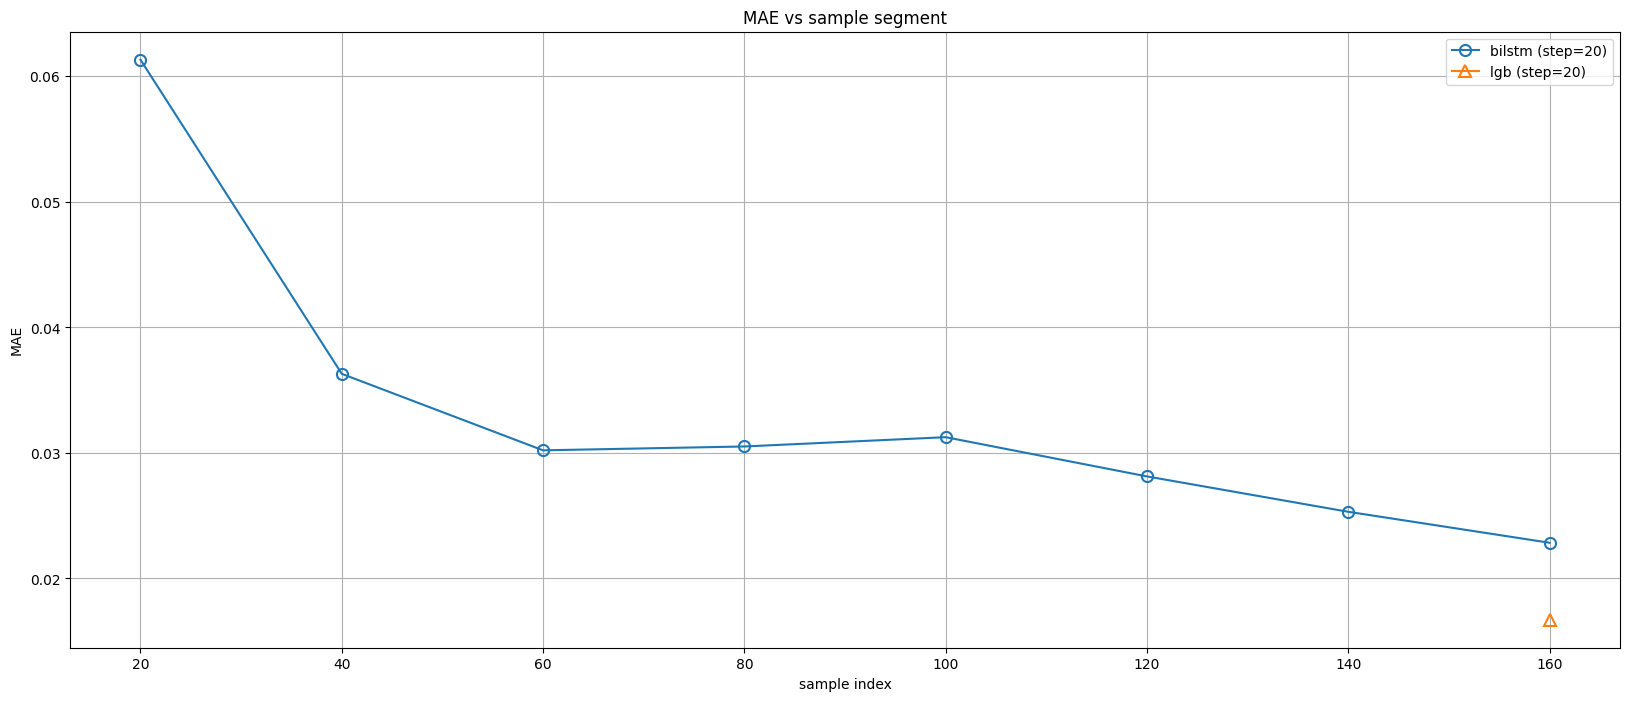

In [9]:
# Visualize the result
plt.figure(figsize=(20, 8))  # Create a single figure
plt.title("MAE vs sample segment")  # Set the title of the plot
plt.xlabel("sample index")  # Label for the x-axis
plt.ylabel("MAE")  # Label for the y-axis

# Define markers for each model
model_markers = {
    'bilstm': 'o',
    'lgb': '^',
}

# Iterate through each model
for model in result['model'].unique():
    marker = model_markers.get(model, 'o')  # Get the marker for the model, default to 'o'

    # Iterate through each step_length
    for step_len in step_len_list:
        print(f"step_len: {step_len}")
        print(f"model: {model}")
        print(f"ordinal: {result['ordinal']}")
        print(f"MAE: {result['MAE']}")
        print(f"result: {result}")
        print(f"result['step_length']: {result['step_length']}")
        print(f"result['model']: {result['model']}")
        # Filter data for the current step_length and model
        subset = result[(result['step_length'] == step_len) & (result['model'] == model)]

        x = subset['ordinal'] * step_len
        y = subset['MAE']
        plt.plot(
            x, y,
            label=f'{model} (step={step_len})',
            marker=marker,  # Use the marker for the model
            linestyle='-',
            markersize=8,
            markerfacecolor='none', 
            markeredgewidth=1.5 
        )

plt.legend()
plt.grid()
plt.show()




=== Evaluating dataset: st ===

Window sizes to evaluate: [10, 20, 30, 40, 50]

--- Window size = 10 ---
  BILSTM Test data shape: (851, 10, 4)
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
  BILSTM Test MAE: 0.018947


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (851, 8)
  LightGBM Test MAE: 0.019411

--- Window size = 20 ---
  BILSTM Test data shape: (416, 20, 4)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
  BILSTM Test MAE: 0.026323


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (416, 8)
  LightGBM Test MAE: 0.016712

--- Window size = 30 ---
  BILSTM Test data shape: (269, 30, 4)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
  BILSTM Test MAE: 0.032441
  LightGBM Test data shape (extracted features): (269, 8)
  LightGBM Test MAE: 0.016817

--- Window size = 40 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (203, 40, 4)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
  BILSTM Test MAE: 0.041561
  LightGBM Test data shape (extracted features): (203, 8)
  LightGBM Test MAE: 0.014065

--- Window size = 50 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (160, 50, 4)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
  BILSTM Test MAE: 0.044467
  LightGBM Test data shape (extracted features): (160, 8)
  LightGBM Test MAE: 0.014821


=== Evaluating dataset: randomized ===

Window sizes to evaluate: [10, 20, 30, 40, 50]

--- Window size = 10 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (699, 10, 4)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  BILSTM Test MAE: 1.180275


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (699, 14)
  LightGBM Test MAE: 2.895676

--- Window size = 20 ---
  BILSTM Test data shape: (340, 20, 4)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
  BILSTM Test MAE: 3.103860


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (340, 14)
  LightGBM Test MAE: 2.640658

--- Window size = 30 ---
  BILSTM Test data shape: (218, 30, 4)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
  BILSTM Test MAE: 4.544897


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (218, 14)
  LightGBM Test MAE: 2.450506

--- Window size = 40 ---
  BILSTM Test data shape: (161, 40, 4)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
  BILSTM Test MAE: 17.645146


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (161, 14)
  LightGBM Test MAE: 2.712768

--- Window size = 50 ---
  BILSTM Test data shape: (123, 50, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
  BILSTM Test MAE: 17.734785
  LightGBM Test data shape (extracted features): (123, 14)
  LightGBM Test MAE: 2.399084


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


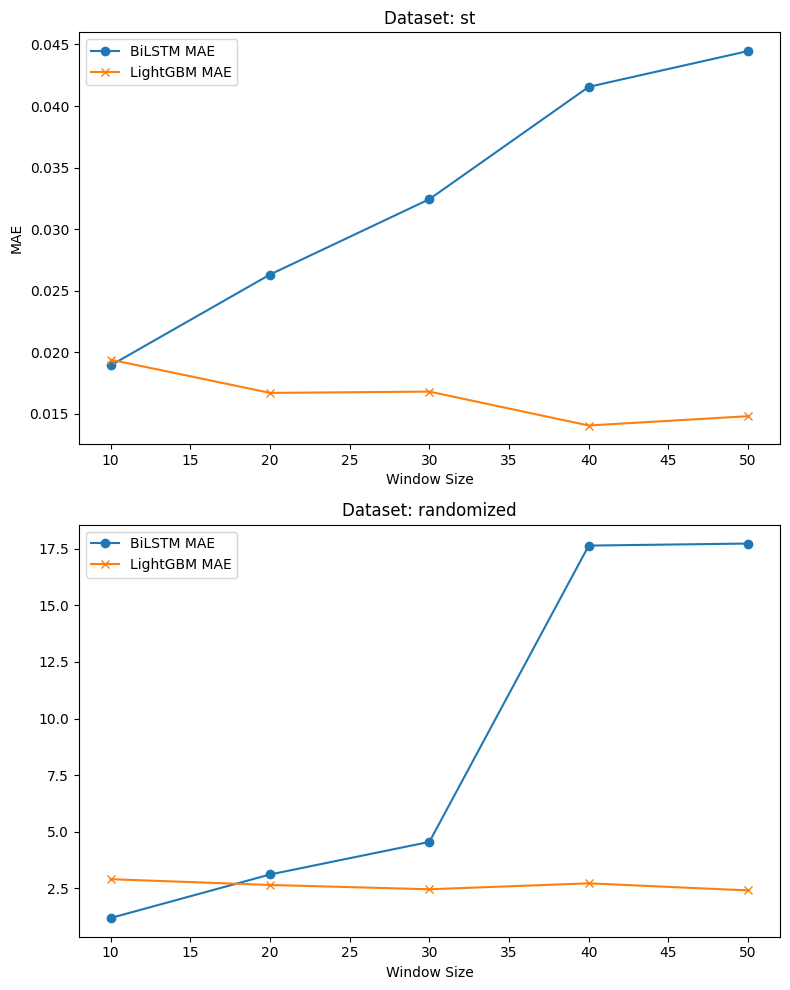

In [16]:


##############################################################################
# 1) Choose which datasets to evaluate
##############################################################################
# If you only have 'st' and 'randomized', set them here:
DATASETS = ["st", "randomized"]  # or just ["st"] if you only want one.

##############################################################################
# 2) Prepare a figure for subplots (one subplot per dataset)
##############################################################################
fig, axes = plt.subplots(nrows=len(DATASETS), ncols=1, figsize=(8, 5 * len(DATASETS)), sharex=False, sharey=False)

if not isinstance(axes, np.ndarray):
    # If there's only one dataset in the list, 'axes' won't be an array.
    axes = [axes]  # make it iterable

##############################################################################
# 3) Loop over each dataset, evaluate BiLSTM vs LightGBM across windows
##############################################################################
for i, ds_name in enumerate(DATASETS):
    ax = axes[i]
    print(f"\n\n=== Evaluating dataset: {ds_name} ===\n")

    ##########################################################################
    # 3.1) Load configurations for BiLSTM and LightGBM
    #      We'll read both YAML files to get the needed info.
    ##########################################################################
    params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    params_lgb    = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)

    # We'll gather the window sizes from the same config you used to train them.
    # Typically, you'd find these in both configs, or just pick one of them.
    window_sizes = []
    if hasattr(params_bilstm, "multi_window_size"):
        window_sizes = params_bilstm.multi_window_size[1:]
    elif hasattr(params_lgb, "multi_window_size"):
        window_sizes = params_lgb.multi_window_size[1:]
    else:
        # fallback if no multi_window_size
        window_sizes = [params_bilstm.sequence_length]

    print(f"Window sizes to evaluate: {window_sizes}")

    ##########################################################################
    # 3.2) Load LightGBM model
    ##########################################################################
    lgbm_model_path = f"models/lightgbm/lgbm_{ds_name}_model.pkl"
    if not os.path.exists(lgbm_model_path):
        print(f"WARNING: LightGBM model not found: {lgbm_model_path}")
        print("Skipping LightGBM evaluation...")
        lgbm_maes = [None] * len(window_sizes)
        lightgbm_available = False
    else:
        with open(lgbm_model_path, "rb") as f:
            lgbm_model = pickle.load(f)
        lightgbm_available = True
        lgbm_maes = []

    ##########################################################################
    # 3.3) Evaluate BiLSTM across multiple window sizes
    ##########################################################################
    bilstm_maes = []
    for w in window_sizes:
        print(f"\n--- Window size = {w} ---")

        ######################################################################
        # (a) Prepare test data for that window
        ######################################################################
        # BILSTM uses the raw numeric windows from `params_bilstm.features`
        ( _, _, _, _, test_s_bi, test_t_bi) = preprocess_and_window(
            data_path    = params_bilstm.data_path,
            sequence_length = w,
            overlap      = params_bilstm.overlap,
            normalize    = params_bilstm.normalize,
            features     = params_bilstm.features,
            labels       = params_bilstm.labels,
            data_groupby = params_bilstm.data_groupby
        )

        print(f"  BILSTM Test data shape: {test_s_bi.shape}")

        # (b) Load the BiLSTM model for this window size
        bilstm_path = f"models/bilstm/{ds_name}_bilstm_win{w}.h5"
        if not os.path.exists(bilstm_path):
            print(f"  WARNING: BiLSTM model not found at {bilstm_path}")
            bilstm_maes.append(None)
        else:
            
            bilstm_model = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanAbsoluteError()})
            pred_bi = bilstm_model.predict(test_s_bi)
            mae_bi = mean_absolute_error(test_t_bi, pred_bi)
            bilstm_maes.append(mae_bi)
            print(f"  BILSTM Test MAE: {mae_bi:.6f}")

        ######################################################################
        # (c) Evaluate LightGBM for this window size (same test *samples*)
        ######################################################################
        if lightgbm_available:
            # LightGBM was trained on extracted features, so do the same extraction
            ( _, _, _, _, test_s_lgb, test_t_lgb) = preprocess_and_window(
                data_path    = params_lgb.data_path,
                sequence_length = w,
                overlap      = params_lgb.overlap,
                normalize    = params_lgb.normalize,
                features     = params_lgb.raw_features,
                labels       = params_lgb.labels,
                data_groupby = params_lgb.data_groupby
            )
            # Convert raw windows to final feature set
            test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
            print(f"  LightGBM Test data shape (extracted features): {test_s_lgb.shape}")

            lgb_pred = lgbm_model.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, lgb_pred)
            lgbm_maes.append(mae_lgb)
            print(f"  LightGBM Test MAE: {mae_lgb:.6f}")

    ##########################################################################
    # 3.4) Plot the results for this dataset
    ##########################################################################
    # Some datasets might not have valid LightGBM or BILSTM arrays, so handle that:
    if len(bilstm_maes) == len(window_sizes):
        ax.plot(window_sizes, bilstm_maes, marker='o', label='BiLSTM MAE')
    if lightgbm_available and len(lgbm_maes) == len(window_sizes):
        ax.plot(window_sizes, lgbm_maes, marker='x', label='LightGBM MAE')

    ax.set_title(f"Dataset: {ds_name}")
    ax.set_xlabel("Window Size")
    if i == 0:
        ax.set_ylabel("MAE")
    ax.legend()
    #############################################################################
# 4) Final display
##############################################################################
plt.tight_layout()
plt.show()
